In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#my_path = "drive/My Drive/data/"
my_path = "data/"

# LSTM + Attention

Nous allons utiliser un modèle comprenant un réseau LSTM ainsi qu'une couche d'attention.

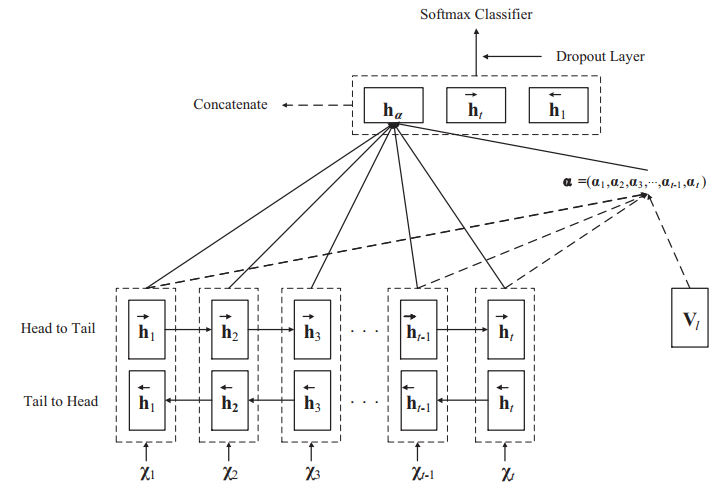

## Préparer les données

In [3]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import pandas as pd
import torch
from torchtext import data

# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True,lower=True, tokenize = 'spacy', include_lengths=True, batch_first=True, fix_length=200)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
test_data, valid_data = torch.split(test_data, 0.5, dim=1) 

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 12500
Taille des données test: 12500


In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 
print(f"Nombre unique de LABEL: {len(LABEL.vocab)}")


# utilisation du GPU si possible 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
device = device, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

Nombre de tokens unique dans le TEXT: 25002
Nombre unique de LABEL: 2


## Construire le modèle

Nous allons incorporer le mécanisme Attention dans notre modèle LSTM. Dans ce nouveau modèle, nous utiliserons l'attention pour calculer le score "soft" d'alignement entre chacun des hidden_state et le dernier hidden_state du LSTM. 

Nous utiliserons torch.bmm pour la multiplication de la matrice par batch.



In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class AttentionModel(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, dropout):
        super(AttentionModel, self).__init__()


        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.weights = word_embeddings

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(word_embeddings, requires_grad=False)
        self.dropout = 0.8
        self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
        # We will use da = 350, r = 30 & penalization_coeff = 1 as per given in the self-attention original ICLR paper
        self.W_s1 = nn.Linear(2*hidden_size, 350)
        self.W_s2 = nn.Linear(350, 30)
        self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
        self.label = nn.Linear(2000, output_size)

    def attention_net(self, lstm_output):

        """
        Nous allons maintenant utiliser le mécanisme d'auto-attention pour produire une matrice d'embeddings de la phrase d'entrée dans laquelle chaque 
        ligne représente un encodage de la phrase d'entrée mais en accordant une attention à une partie spécifique de la phrase. 
        Nous utiliserons 30 de ces embeddings de la phrase d'entrée et enfin nous concaténerons tous les 30 vecteurs d'embedding 
        de phrases et les connecterons à une couche connectée de taille 2000 qui sera connectée à la couche de sortie de taille 2 renvoyant 
        des logits pour nos deux classes.
        Arguments
        ---------
        lstm_output = Un tenseur contenant des états cachés correspondant à chaque pas de temps du réseau LSTM.
        ---------
        Returns : Matrice de pondération de l'attention finale pour les 30 enchaînements de phrases différents dans lesquels chacun des 30 embeddings donne
                  une attention aux différentes parties de la phrase d'entrée..
        Tensor size : lstm_output.size() = (batch_size, num_seq, 2*hidden_size)
                  attn_weight_matrix.size() = (batch_size, 30, num_seq)
        """
        attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
        attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
        attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

        return attn_weight_matrix

    def forward(self, input_sentences, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence taille = (batch_size, num_sequences)
        batch_size : default = None. Utilisé uniquement pour la prédiction sur une seule phrase après l'entraînement (batch_size = 1)
        
        Returns
        -------
        Sortie de la couche linéaire contenant les logits pour la classe positive & négative.
        
        """

        input = self.dropout(self.word_embeddings(input_sentences))
        input = input.permute(1, 0, 2)
        if batch_size is None:
            h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

        output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
        output = output.permute(1, 0, 2)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        # h_n.size() = (1, batch_size, hidden_size)
        # c_n.size() = (1, batch_size, hidden_size)
        attn_weight_matrix = self.attention_net(output)
        # attn_weight_matrix.size() = (batch_size, r, num_seq)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        hidden_matrix = torch.bmm(attn_weight_matrix, output)
        # hidden_matrix.size() = (batch_size, r, 2*hidden_size)
        # Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
        fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
        logits = self.label(fc_out)
        # logits.size() = (batch_size, output_size)

        return logits

In [6]:
import torch.nn as nn
from torch.autograd import Variable
batch_size = 32
output_size = 2 # 2 labels 
hidden_size = 256 
embedding_length = 300 # dimension de GloVe word embeddings
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)
dropout = 0.8

model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings,dropout)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 39,559,466 paramètres à entraîner


In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion =  F.cross_entropy
model = model.to(device)


def binary_accuracy(preds, y):
    """
    Retourne l'accuracy par batch
    """
    #arrondi la prédiction à l'entier le plus proche
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [9]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text = batch.text[0]
        target = batch.label 

        
        if (text.size()[0] is not batch_size):
            continue
        predictions = model(text)
        target = torch.autograd.Variable(target).long()
        loss = criterion(predictions, target)
        pred = torch.max(predictions, 1)[1].view(target.size()).data
        acc = binary_accuracy(pred.float(), target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()      
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
      
    epoch_loss = 0
    epoch_acc = 0
      
    model.eval()
      
    with torch.no_grad():
      
        for batch in iterator:

            text = batch.text[0]
            if (text.size()[0] is not batch_size):
                continue
            target = batch.label 
            predictions = model(text)
            target = torch.autograd.Variable(target).long()
            loss = criterion(predictions, target )
            pred = torch.max(predictions, 1)[1].view(target.size()).data
            acc = binary_accuracy(pred.float(), target)
              
            epoch_loss += loss.item()
            epoch_acc += acc.item()
          
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

tloss = []
tacc = []
vloss = []
vacc = []

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc) 
    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)   
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



TypeError: 'float' object is not callable

On trouve une valeur d'accuracy d'environ 80% pour les données de validation.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

In [ ]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

## Test

On teste le modèle sur notre jeu de données test.

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor, 1)
    out = F.softmax(prediction, 1)
    if (torch.argmax(out[0]) == 0):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")

predict_sentiment(model, "this film is not good ")

predict_sentiment(model, "This film is great amazing good ")

On remarque que contrairement aux modèles précédents ce modèle prend en compte la négation.

## Références